In [25]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

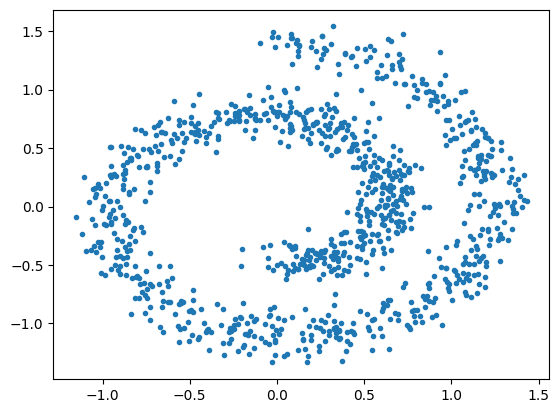

In [26]:
import matplotlib.pyplot as plt
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

In [19]:
from layers.hyp_layers import LorentzLinear
from manifolds import Lorentz
import torch.nn as nn
class Score_Model(nn.Module):
    def __init__(self):
        super(Score_Model, self).__init__()
        self.c = torch.tensor([1.0])
        #account for time as well

        self.manifold = Lorentz()

        self.layers = torch.nn.Sequential(
            LorentzLinear(self.manifold, 3, 17, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            LorentzLinear(self.manifold, 17, 33, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            LorentzLinear(self.manifold, 33, 65, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            LorentzLinear(self.manifold, 65, 65, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            LorentzLinear(self.manifold, 65, 3, self.c, dropout=0., nonlin=torch.nn.ReLU()),
        )
        t_layer = []
        t_dims = [1, 8, 16, 8, 1]
        for i in range(len(t_dims) - 2):
                t_layer.append(torch.nn.Linear(t_dims[i], t_dims[i+1]))
                t_layer.append(nn.ReLU())
        t_layer.append(torch.nn.Linear(t_dims[-2], t_dims[-1]))
        self.t_layers = nn.Sequential(*t_layer )
    def forward(self, x, t=None):
        xt = x.clone()
        t = self.t_layers(t)
        x = self.layers(x)
        x = self.manifold.logmap(xt, x)
        output = x * t
        return output


In [20]:
def hyp_calc_loss(input, y) -> torch.Tensor:
    f = input
    x = y[..., 1:]
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    xe_t = torch.randn_like(x) * var_t ** 0.5 + mu_t

    x_time = ((xe_t ** 2).sum(-1, keepdims=True) + 1.).clamp_min(1e-6).sqrt()
    x_t = torch.cat([x_time, xe_t], dim=-1)

    sq_norm = (torch.sum(xe_t ** 2, dim = -1, keepdim=True) + 1).clamp_min(1e-6).sqrt()
    grad_0 = xe_t / (sq_norm.clamp_min(1e-6))
    grad_rest = torch.eye(xe_t.size(1), device=xe_t.device).expand(xe_t.size(0), -1, -1)
    grad_proj = torch.cat([grad_0.unsqueeze(1), grad_rest], dim=1)
    
    beta_t = 0.1 + (20 - 0.1) * t
    
    grad_log_p = -(xe_t - mu_t) / var_t
    target = (grad_proj.bmm((-0.5 * beta_t * xe_t - (beta_t ** 2) * grad_log_p).unsqueeze(dim=-1)).squeeze(dim=-1))
    f_star = f(x_t, t)
    loss = (target - f_star) ** 2
    return torch.mean(loss)

In [21]:
import time
from optim.radam import RiemannianAdam
score_model = Score_Model()
opt = torch.optim.Adam(score_model.parameters(), lr=0.001, weight_decay=1e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
manifold = Lorentz()
for i_epoch in range(150000):
    total_loss = 0
    for data, in dloader:
        data = torch.cat([torch.zeros_like(data)[..., 0:1], data], dim=-1)
        data = manifold.expmap0(data)
        opt.zero_grad()
        loss = hyp_calc_loss(score_model, data)
        loss.backward()
        opt.step()
        
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    if i_epoch % 10000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

0 (0.017354965209960938s): 36537.15175
10000 (116.23665618896484s): 345.86715185546876
20000 (232.91573119163513s): 343.634236328125
30000 (349.39140033721924s): 322.28328979492187
40000 (465.5098900794983s): 341.4681462402344
50000 (581.6038861274719s): 338.5405861816406
60000 (697.6471421718597s): 308.14712426757814
70000 (813.5563130378723s): 353.74282421875
80000 (929.5706400871277s): 326.12696557617187
90000 (1045.5962550640106s): 325.6556501464844
100000 (1161.4614851474762s): 340.70757592773435
110000 (1277.3871710300446s): 319.3836604003906
120000 (1392.9334440231323s): 359.628052734375
130000 (1508.7262032032013s): 334.8997653808594
140000 (1625.176040172577s): 316.68595336914063


In [22]:
from tqdm import trange
from manifolds import Lorentz
manifold = Lorentz()
def sample(score_model):
    xe_t = torch.randn((1000, 2))
    x_time = ((xe_t ** 2).sum(dim=-1, keepdims=True) + 1.0).clamp_min(1e-6).sqrt()
    x_t = torch.cat([x_time, xe_t], dim=-1)
    time_pts = torch.linspace(1, 0, 1000, device=xe_t.device)
    for i in trange(0, (1000 - 1), desc = '[Sampling]', position = 1, leave=False):
        x_ori = x_t.clone()
        t = torch.ones(xe_t.shape[0], 1, dtype=x_t.dtype, device=x_t.device) * time_pts[i]
        dt = torch.ones(xe_t.shape[0], 1, dtype=x_t.dtype, device=x_t.device) * time_pts[i + 1] - t
        xe_t = x_t[..., 1:]
        score = score_model(x_t, t)
        dW = torch.randn_like(xe_t, device=xe_t.device).unsqueeze(dim=-1)            
        sq_norm = (torch.sum(xe_t ** 2, dim = -1, keepdim=True) + 1).clamp_min(1e-6).sqrt()
        grad_0 = xe_t / (sq_norm.clamp_min(1e-6))
        grad_rest = torch.eye(xe_t.size(1), device=xe_t.device).expand(xe_t.size(0), -1, -1)
        grad_proj = torch.cat([grad_0.unsqueeze(1), grad_rest], dim=1)
        beta_t = 0.1 + (20 - 0.1) * t
        h_diffusion = grad_proj
        x_h = score * dt + h_diffusion.bmm(dW).squeeze(dim=-1) * (torch.abs(dt).sqrt()) * beta_t.sqrt()
        x_t = manifold.expmap(x_ori, x_h)
    return x_t

In [23]:
samples = sample(score_model).detach()
sampled = manifold.logmap0(samples)
sampled = sampled[..., 1:]

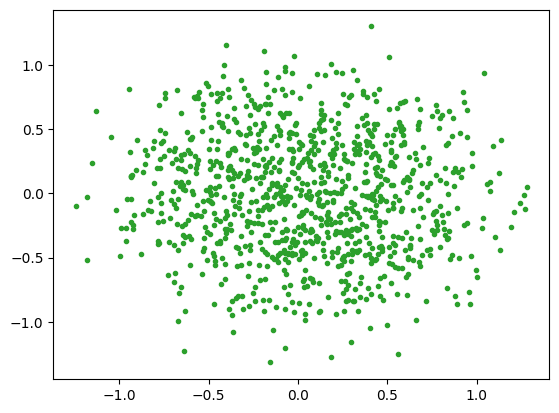

In [24]:
import matplotlib.pyplot as plt
plt.plot(sampled[:, 0], sampled[:, 1], 'C2.')

In [615]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.c = torch.tensor([1.0])

        self.manifold = Lorentz()

        self.encoder1 = torch.nn.Sequential(
            torch.nn.Linear(2, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 8),
            torch.nn.ReLU(),
        )

        self.encoder2 = torch.nn.Sequential(
            LorentzLinear(self.manifold, 9, 9, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            # LorentzLinear(self.manifold, 3, 3, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            LorentzLinear(self.manifold, 9, 9, self.c, dropout=0., nonlin=None)
        )

        self.decoder = torch.nn.Sequential(
            LorentzLinear(self.manifold, 9, 9, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            # LorentzLinear(self.manifold, 3, 3, self.c, dropout=0., nonlin=torch.nn.ReLU()),
            LorentzLinear(self.manifold, 9, 9, self.c, dropout=0., nonlin=None),
            torch.nn.Linear(9, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 2),
        )

    def forward(self, x):
        x = self.encoder1(x)
        x = torch.cat([torch.zeros_like(x)[..., 0:1], x], dim=-1)
        x = self.manifold.expmap0(x)
        encoded_emb = self.encoder2(x)
        decoded_emb = self.decoder(encoded_emb)
        output = (encoded_emb, decoded_emb)
        return output

In [617]:
import time
autoencoder = Autoencoder()
opt_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01, weight_decay=0)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
manifold = Lorentz()
loss_fn = torch.nn.MSELoss()
for i_epoch in range(100):
    total_loss = 0
    for data, in dloader:
        opt_ae.zero_grad()
        _, emb = autoencoder(data)
        loss = loss_fn(emb, data)
        loss.backward()
        opt_ae.step()
        
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    if i_epoch % 10 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

0 (0.009796857833862305s): 1.295014633178711
10 (0.08203697204589844s): 0.22825201177597046
20 (0.14876174926757812s): 0.06162055239081383
30 (0.21787691116333008s): 0.004258279904723167
40 (0.2997429370880127s): 0.0017365299984812737
50 (0.379580020904541s): 0.0009551343396306038
60 (0.45833778381347656s): 0.0008192887953482568
70 (0.527512788772583s): 0.0012151811653748155
80 (0.5962247848510742s): 0.0015206706272438168
90 (0.6645870208740234s): 0.0024980583880096674


In [27]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    x = x[..., 1:]
    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-8) + 1e-8

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, 2)
    
    # calculate the score function
    xt = torch.cat((x_t, t), dim=-1)  # (batch_size, 3)
    score = score_network(xt)  # score: (batch_size, 2)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)

In [28]:
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

In [30]:
import time
from optim.radam import RiemannianAdam
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4, weight_decay=0)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
manifold = Lorentz()
# for name, param in autoencoder.named_parameters():
#     param.requires_grad = False
for i_epoch in range(150000):
    total_loss = 0
    for data, in dloader:
        # emb = autoencoder.encoder1(data)
        emb = data
        emb = torch.cat([torch.zeros_like(emb)[..., 0:1], emb], dim=-1)
        emb = manifold.expmap0(emb)
        # emb = autoencoder.encoder2(emb)
        opt.zero_grad()
        loss = calc_loss(score_network, emb)
        loss.backward()
        opt.step()
        
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    if i_epoch % 10000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

0 (0.2404930591583252s): 1.0104420828819274
10000 (49.438730001449585s): 0.24287255311012268
20000 (96.65654301643372s): 0.25031573748588565
30000 (145.6434681415558s): 0.255457466840744
40000 (194.45717406272888s): 0.24356824338436125
50000 (243.32178473472595s): 0.23254420721530913
60000 (292.51181387901306s): 0.24041395890712738
70000 (341.7138669490814s): 0.25564853310585023
80000 (390.6677198410034s): 0.20081371760368347
90000 (442.3895239830017s): 0.243552747964859
100000 (492.6642818450928s): 0.24458205878734587
110000 (541.9000089168549s): 0.2107876079082489
120000 (591.0210959911346s): 0.24619027364253998
130000 (642.2740309238434s): 0.23430226671695709
140000 (693.1324279308319s): 0.21180622005462646


In [31]:
from tqdm import trange
from manifolds import Lorentz
manifold = Lorentz()
def sample(score_model):
    xe_t = torch.randn((1000, 2))
    x_time = ((xe_t ** 2).sum(dim=-1, keepdims=True) + 1.0).clamp_min(1e-6).sqrt()
    x_t = torch.cat([x_time, xe_t], dim=-1)
    time_pts = torch.linspace(1, 0, 1000, device=xe_t.device)
    for i in trange(0, (1000 - 1), desc = '[Sampling]', position = 1, leave=False):
        x_ori = x_t.clone()
        t = time_pts[i]
        dt = time_pts[i + 1] - t
        xe_t = x_t[..., 1:]
        score = score_model(torch.cat((xe_t, t.expand(xe_t.shape[0], 1)), dim=-1)).detach()
        dW = torch.randn_like(xe_t, device=xe_t.device).unsqueeze(dim=-1)            
        sq_norm = (torch.sum(xe_t ** 2, dim = -1, keepdim=True) + 1).clamp_min(1e-6).sqrt()
        grad_0 = xe_t / (sq_norm.clamp_min(1e-6))
        grad_rest = torch.eye(xe_t.size(1), device=xe_t.device).expand(xe_t.size(0), -1, -1)
        grad_proj = torch.cat([grad_0.unsqueeze(1), grad_rest], dim=1)
        beta_t = 0.1 + (20 - 0.1) * t
        h_diffusion = grad_proj
        x_h = manifold.proju(x_ori, (grad_proj.bmm((-0.5 * beta_t * xe_t - (beta_t ** 2) * score).unsqueeze(dim=-1)).squeeze(dim=-1)) * dt + h_diffusion.bmm(dW).squeeze(dim=-1) * (torch.abs(dt).sqrt()) * beta_t.sqrt())
        assert(not xe_t.isnan().any())
        assert(not xe_t.isinf().any())
        assert(not grad_proj.isnan().any())
        assert(not grad_proj.isinf().any())
        assert(not score.isinf().any())
        assert(not score.isnan().any())
        assert(not x_h.isnan().any())
        assert(not x_h.isinf().any())
        dim = -1
        d = x_h.size(dim) - 1
        uv = x_h * x_ori
        a = torch.max(torch.abs(-uv.narrow(dim, 0, 1).squeeze(dim) + uv.narrow(dim, 1, d).sum(dim=dim, keepdim=False)))
        if a >= 1e-4:
            print(a)
            print(t)
            print(i)
            assert(1==2)
        x_t = manifold.expmap(x_ori, x_h)
        assert(not x_t.isnan().any())
        assert(not x_t.isinf().any())
    assert(not x_t.isnan().any())
    assert(not x_t.isinf().any())
    return x_t

In [33]:
samples = sample(score_network).detach()
sampled = manifold.logmap0(samples)[..., 1:]
# samples = autoencoder.decoder(samples)
# sampled = autoencoder.decoder1(samples)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x9 and 3x64)

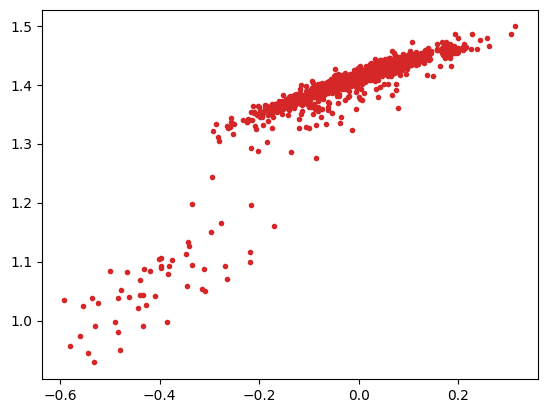

In [628]:
import matplotlib.pyplot as plt
plt.plot(sampled[:, 0], sampled[:, 1], 'C3.')